# Accelerated and adaptive stochastic gradient methods

The main limitation of basic gradient-type methods is their slow convergence, a
behaviour often attributed to the difficulty of selecting an appropriate step size. To address this challenge, a wide range of accelerated and adaptive variants of stochastic gradient descent (SGD) have been developed. In this notebook, we study the most commonly used ones:
- SGD with momentum
- Nesterov Accelerated Gradient (NAG)
- AdaGrad
- Adam

All methods are applied to regularized logistic regression on an ill-conditioned
synthetic dataset.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

os.makedirs("csv_synthetic", exist_ok=True)

# Quick knob
FAST_MODE = True
EPOCHS = 2000 if FAST_MODE else 5000

## 2. Synthetic logistic regression problem

We generate a binary classification dataset with gaussian features and outputs generated with a logistic link function.

In order to obtain an ill-conditioned dataset, we impose a strong feature-wise scaling, so that different parameters
have vastly different sensitivities.

In [4]:
def make_synthetic_logistic(m=5000, n=40, seed=0):
    rng = np.random.default_rng(seed)

    X = rng.normal(size=(m, n))
    scales = np.logspace(0, 3, n)      # feature anisotropy
    X = X * scales

    w_true = rng.normal(size=n)
    logits = X @ w_true
    p = 1.0 / (1.0 + np.exp(-logits))
    y = rng.binomial(1, p)

    return X.astype(np.float64), y.astype(np.int32), w_true


X, y, _ = make_synthetic_logistic(m=6000, n=20, seed=0)
print("X shape:", X.shape, "| class balance:", y.mean())

X shape: (6000, 20) | class balance: 0.49266666666666664


/var/folders/pv/7xq94jdd4d51wrjpm4h32qj00000gn/T/ipykernel_7275/663124418.py:10: RuntimeWarning: overflow encountered in exp
  p = 1.0 / (1.0 + np.exp(-logits))


## 3. Logistic regression objective

We minimize the regularized logistic loss:
$$f(\theta) = \frac{1}{n}\sum_{i=1}^n \ell(x_i^\top \theta, y_i) + \frac{\gamma}{2}\|\theta\|^2,$$
where $\gamma>0$ and
$$\ell(z,y) = -y\log \sigma(z) - (1-y)\log(1-\sigma(z)).$$



In [5]:
def sigmoid(z):
    """Numerically stable sigmoid to avoid overflow."""
    z = z.astype(np.float64, copy=False)
    out = np.empty_like(z, dtype=np.float64)
    # Handle positive and negative values separately
    pos = z >= 0
    neg = ~pos
    out[pos] = 1.0 / (1.0 + np.exp(-z[pos]))
    ez = np.exp(z[neg])
    out[neg] = ez / (1.0 + ez)
    return out


def logloss(w, X, y, gamma=1e-4):
    """Logistic loss with L2 regularization."""
    z = X @ w
    p = sigmoid(z)
    eps = 1e-12  # Avoid log(0)
    # Binary cross-entropy
    loss = -np.mean(y * np.log(p + eps) + (1 - y) * np.log(1 - p + eps))
    loss += 0.5 * gamma * np.sum(w**2)
    return float(loss)


def grad_logloss(w, X, y, gamma=1e-4):
    """Gradient of logistic loss with L2 penalty."""
    z = X @ w
    p = sigmoid(z)
    grad = (X.T @ (p - y)) / X.shape[0]
    grad += gamma * w
    return grad

## 4. Reference optimum $f(\theta^*)$
We will measure progress in the optimization through suboptimality:  $f(\theta_k) - f(\theta^*)$.
A reliable reference value $f(\theta^*)$ can be computed via Newton's method. To save computational time we provide here
 a precomputed value.
The Newton solution method is also provided and can be optionally run.  

In [6]:
# Fast option: use precomputed f_opt
f_opt = 1.101595433540e-03
print("Using precomputed f_opt =", f_opt)


def newton_solve_opt(X, y, lam=1e-4, tol=1e-10, max_iter=50):
    d = X.shape[1]
    w = np.zeros(d)

    for it in range(max_iter):
        g = grad_logloss(w, X, y, lam)
        ng = np.linalg.norm(g)
        if ng < tol:
            print(f"[Newton] Converged in {it} iterations | ||g||={ng:.2e}")
            break

        H = hess_logloss_full(w, X, y, lam)
        step = np.linalg.solve(H, g)
        w = w - step

    f_star = logloss(w, X, y, lam)
    print(f"[Newton] f* = {f_star:.12e}")
    return w, f_star

# Uncomment to recompute  f_opt (slow, but nexessary if data, or reg. parameter changes)
# w_star, f_opt = newton_solve_opt(X, y, lam=LAMBDA)

Using precomputed f_opt = 0.00110159543354


## 5. Optimizer update rules

We summarize here the update rules for the different methods that we will test. Let $g_k$ be a (possibly stochastic) estimate  of  $\nabla f(\theta_k)$ and let $\alpha>0$ be a step size.  

### SGD
$$\theta_{k+1} = \theta_k - \alpha g_k$$





### Nesterov Accelerated Gradient (NAG)
NAG computes the gradient in a look-ahaed position:
$$
v_{k+1} = \beta v_k + \nabla f(\theta_k - \alpha\beta v_k), \;\beta\in(0,1)
$$


### AdaGrad
AdaGrad updates parameters $\theta$ at iteration $k$ in component-wise manner, i.e.,
\begin{equation}
\theta_{k+1}(i) = \theta_{k}(i) - \frac{\alpha}{\sqrt{G_k(i) + \epsilon}} \, g_k(i),\quad G_k(i)=\sum_{j=1}^k g_j(i)^2.
\end{equation}
where the symbol $(i)$ denotes i-th component of the vector.



### Adam
Adam combines adaptive learning rates with momentum.
This is achieved by maintaining exponentially decaying averages of past gradients (first moment) and squared gradients (second moment):
\begin{align*}
m_k(i) &= \beta_1 m_{k-1}(i) + (1-\beta_1) g_k(i), \,\beta_1\in(0,1)\\
v_k(i) &= \beta_2 v_{k-1}(i) + (1-\beta_2) (g_k(i))^2, \,\beta_2\in(0,1)
\end{align*}
which are then bias-corrected as
\begin{align*}
\hat{m}_k(i) &= \frac{m_k(i)}{1-\beta_1^k}, \\
\hat{v}_k(i) &= \frac{v_k(i)}{1-\beta_2^k}.
\end{align*}
These moments are then used to update the current iterate in the following, component-wise, manner:
$$
\theta_{k+1}(i)= \theta_{k}(i) - \alpha \frac{\hat{m}_k(i)}{\sqrt{\hat{v}_k(i)} + \epsilon}.
$$


## 6. Unified optimizer runner

We implement a single driver that supports multiple optimizers, tracks per-epoch loss, suboptimality, and direction variance and allows for fair comparison under identical conditions

In [7]:
def run_optimizer(
    X, y, lam=1e-4,
    epochs=300, batch_size=16,
    optimizer="sgd",
    eta0=1e-3,
    beta=0.9,
    beta1=0.9, beta2=0.999,
    eps=1e-8,
    seed=0, f_opt=None
):

    n, d = X.shape
    rng = np.random.default_rng(seed)
    w = np.zeros(d)

    # State variables
    v = np.zeros_like(w)        # momentum velocity
    m = np.zeros_like(w)        # first moment (Adam / AdaGrad)
    v2 = np.zeros_like(w)       # second moment (Adam)

    hist = {
        "epoch": [],
        "loss": [],
        "subopt": [],
        "dir_var": [],
        "optimizer": []
    }

    for ep in range(epochs):
        idx = rng.permutation(n)
        Xs, ys = X[idx], y[idx]

        dirs = []   # store update directions within the epoch

        for start in range(0, n, batch_size):
            end = min(start + batch_size, n)
            Xb, yb = Xs[start:end], ys[start:end]

            g = grad_logloss(w, Xb, yb, lam)

            if optimizer == "SGD":
                d = -eta0 * g

            elif optimizer == "momentum":
                v = beta * v + g
                d = -eta0 * v

            elif optimizer == "NAG":
                w_look = w - eta0 * beta * v
                g = grad_logloss(w_look, Xb, yb, lam)
                v = beta * v + g
                d = -eta0 * v

            elif optimizer == "AdaGrad":
                m += g * g
                d = -eta0 * g / (np.sqrt(m) + eps)

            elif optimizer == "Adam":
                m = beta1 * m + (1 - beta1) * g
                v2 = beta2 * v2 + (1 - beta2) * (g * g)
                m_hat = m / (1 - beta1 ** (ep + 1))
                v_hat = v2 / (1 - beta2 ** (ep + 1))
                d = -eta0 * m_hat / (np.sqrt(v_hat) + eps)

            else:
                raise ValueError("Unknown optimizer")

            dirs.append(d)
            w += d

        # Epoch-level statistics
        f = logloss(w, X, y, lam)
        hist["epoch"].append(ep)
        hist["loss"].append(f)
        hist["subopt"].append(f - f_opt)
        hist["optimizer"].append(optimizer)


    return hist

## 7. Comparison of different optimizers

We compare optimizers in the *full-batch* regime to isolate
the effect of update rules rather than sampling noise.

In [8]:
optimizers = ["SGD", "NAG", "AdaGrad", "Adam"]
lr_rates = [1e-4, 1e-4, 1e-2, 1e-2]

histories = {}

for opt, lr in zip(optimizers, lr_rates):
    print(f"Running {opt} with lr={lr}")
    h = run_optimizer(
        X, y,
        epochs=EPOCHS,
        batch_size=X.shape[0],
        eta0=lr,
        optimizer=opt,
        f_opt=f_opt
    )
    histories[opt] = h


Running SGD with lr=0.0001
Running NAG with lr=0.0001
Running AdaGrad with lr=0.01
Running Adam with lr=0.01


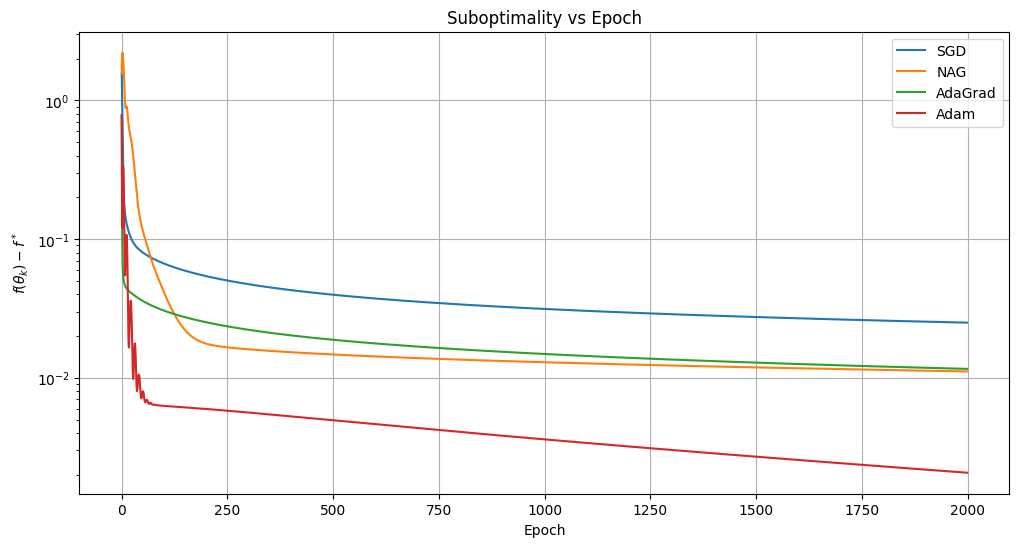

In [9]:
plt.figure(figsize=(12,6))

for opt in optimizers:
    h = histories[opt]
    plt.semilogy(h["epoch"], h["subopt"], label=opt)

plt.title("Suboptimality vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("$f(\\theta_k) - f^*$")
plt.grid(True)
plt.legend()
plt.show()

## Discussion

We can see that **SGD** struggles on ill-conditioned problems and shows a slow convergence. Thanks to the momentum technique,  **NAG** improves the convergence, but do not fully correct anisotropy.

Adaptive methods implicitly apply **diagonal preconditioning**, which partially
approximates second-order curvature information and speeds-up convergence. However, **AdaGrad** may still stall due to the too aggressive learning rate decay, caused by the accumulation of the gradients.
**Adam** outperforms the other methods by combining momentum and adaptive scaling.